# Evaluate success of events - bottom plot needs footfall_spatial env

In [1]:
import pandas as pd
import numpy as np
import folium
import branca.colormap as cm
import joblib
import os
import io
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
from shapely.geometry import Point
import geopandas as gpd
import contextily as cx

from Functions import *

/opt/homebrew/anaconda3/envs/py310/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [2]:
api = "6c2695a3-768a-4885-a408-5770a99f5269"

### Load fitted model

In [4]:
buffer_size_m = 400
#rf_model_pipeline1 = joblib.load(f'Results/FinalModels/rf_model_pipeline1_{buffer_size_m}.pkl')
rf_model_pipeline1 = joblib.load(f'Results/FinalModels/rf_model_pipeline1_{buffer_size_m}_outlierremovaleachsensor.pkl')


### Read in Melbourne sensor location data

In [5]:
melbourne_sensors = pd.read_csv("../Cleaned_data/SensorData/sensor_locations.csv")
melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)

### Get data to make prediction on 

In [8]:
input_csv="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}_outlierremovaleachsensor.csv".format(buffer_size_m)
Xfull, Yfull, data_time_columns, index2019 = prepare_x_y_data(input_csv)
sensor_ids = pd.read_csv(input_csv)['sensor_id']

/Users/geonsm/gp/footfall/MelbourneAnalysis/3. Modelling/Functions.py:28: DtypeWarning: Columns (5,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(input_csv, index_col = False)
/var/folders/bx/3j5z8qc50wl1tcff6xvbf2zh0000gs/T/ipykernel_45196/2249439461.py:3: DtypeWarning: Columns (5,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  sensor_ids = pd.read_csv(input_csv)['sensor_id']


### Get data for just one day 

In [9]:
Xfull_with_dates = Xfull.copy()
Xfull['datetime'] = data_time_columns['datetime']
Xfull['datetime'] = pd.to_datetime(Xfull['datetime'], errors='coerce')

# Date of interest
special_date =  '2015-04-25' # '2015-04-25' # 2019-01-01 #2020-03-20

# Get data just from this date
special_date_data = Xfull[Xfull['datetime'].dt.strftime('%Y-%m-%d') == special_date].copy()

# Get real vals from just this date
special_date_real_vals = pd.DataFrame({'Real_vals':Yfull, 'Hour': data_time_columns['time'],'datetime':data_time_columns['datetime']})
special_date_real_vals['datetime'] = pd.to_datetime(special_date_real_vals['datetime'], errors='coerce')
special_date_real_vals = special_date_real_vals[special_date_real_vals['datetime'].dt.strftime('%Y-%m-%d') == special_date].copy()

In [10]:
special_date_real_vals = pd.DataFrame({'Real_vals':Yfull, 'Hour': data_time_columns['time'],'datetime':data_time_columns['datetime'],
                                      'sensor_id': sensor_ids})
special_date_real_vals['datetime'] = pd.to_datetime(special_date_real_vals['datetime'], errors='coerce')
special_date_real_vals = special_date_real_vals[special_date_real_vals['datetime'].dt.strftime('%Y-%m-%d') == special_date].copy()

### Prepare it for using the model to make predictions

In [12]:
# After NM changes these variables are no longer included anyway so don't need to be dropped:
## If using the cyclical variables
#special_date_data.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
#       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
#       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'year', 'datetime'], axis=1, inplace = True)

# But these do need dropping:
special_date_data.drop(['day', 'datetime', 'year'], axis=1, inplace = True)

### Use the model to make predictions

In [13]:
preds = rf_model_pipeline1.predict(special_date_data)

### Make a dataframe containing the model's predictions and the real values

In [14]:
df_preds_real_vals = pd.DataFrame({'Preds':preds,'RealVals':special_date_real_vals['Real_vals'], 
                                   'Hour': special_date_real_vals['Hour'],
                                  'sensor_id': special_date_real_vals['sensor_id']})

### Find the sum of the values across all sensors for each hour

In [15]:
df_preds_real_vals_hourly =df_preds_real_vals.groupby(['Hour']).sum()

### Add percentage increase

In [16]:
df_preds_real_vals_hourly['Percentage_Increase'] = ((df_preds_real_vals_hourly['RealVals'] - df_preds_real_vals_hourly['Preds']) / abs(df_preds_real_vals_hourly['Preds'])) * 100

## Make line plot

In [17]:
include_percent_increase = True

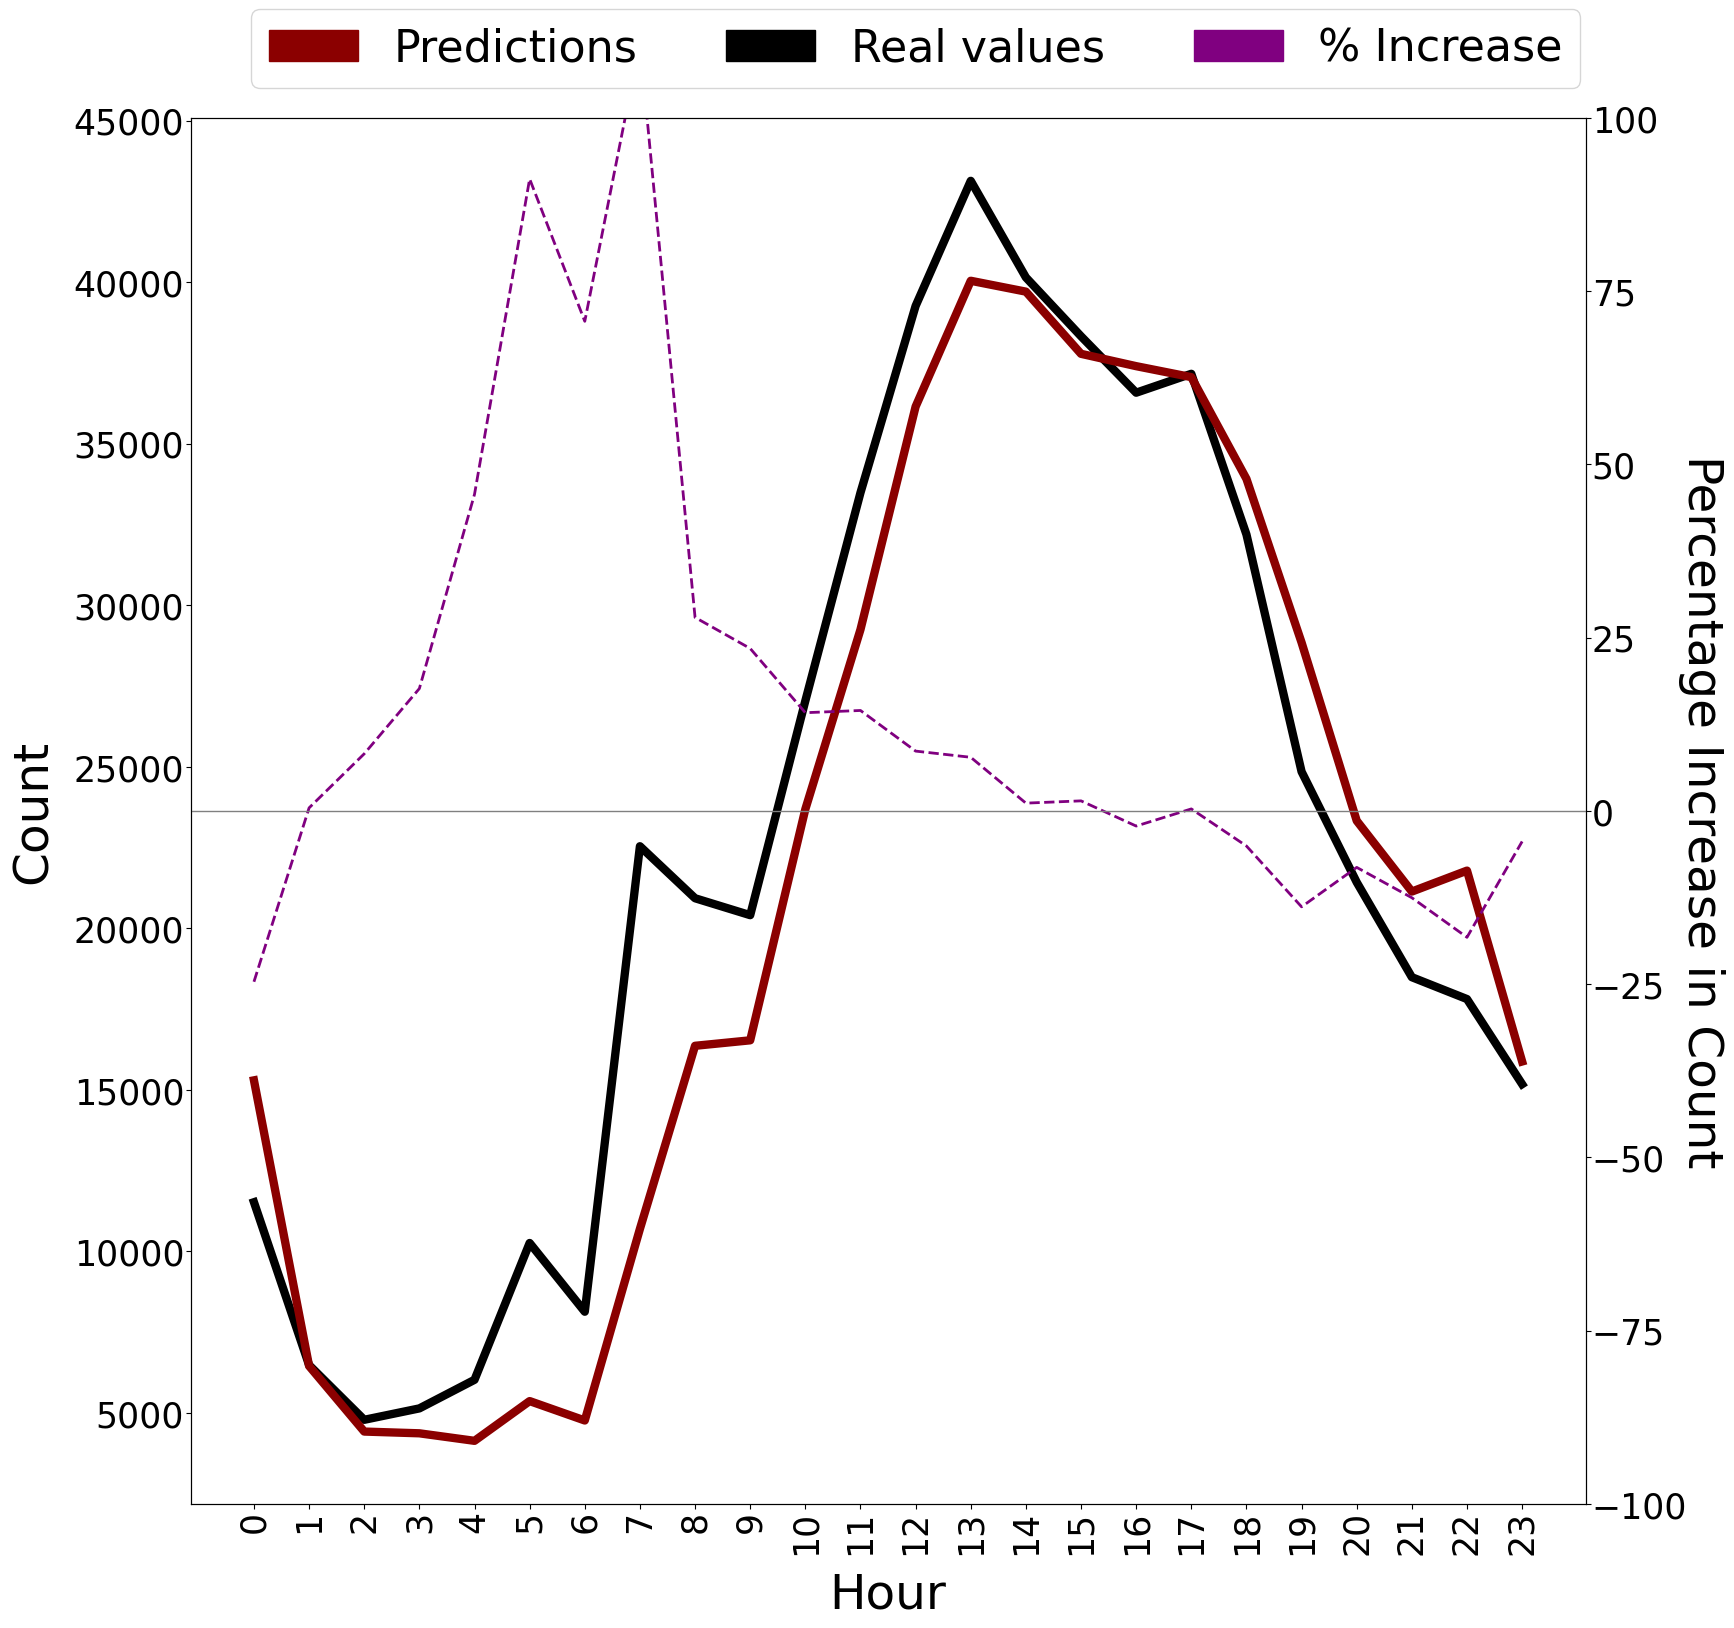

In [18]:
fig, ax = plt.subplots(figsize = (18,18), sharex = True)

fig = df_preds_real_vals_hourly['RealVals'].plot(ax=ax, color='black', linewidth=6, legend =False)
fig = df_preds_real_vals_hourly['Preds'].plot(ax=ax, color='darkred', linewidth=6, legend =False)

colors_leg = ['darkred', 'black', 'purple']
texts = ['Predictions', 'Real values','% Increase'] 
patches = [ mpatches.Patch(color=colors_leg[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]    

ax.set_xticks(range(0,len(df_preds_real_vals_hourly.index)))
ax.set_xticklabels(df_preds_real_vals_hourly.index, size=15)
ax.tick_params(axis='both', which='major', labelsize=25, pad=1)

ax.set_xlabel('Hour', fontsize = 35, labelpad=12)
ax.set_ylabel ('Count',fontsize=35, labelpad=12)

if include_percent_increase==True:
    ax2 = ax.twinx()
    fig = df_preds_real_vals_hourly['Percentage_Increase'].plot(ax=ax2, color='purple', linewidth=2, legend =False,
                                                               linestyle = 'dashed')
    ax2.set_ylabel('Percentage Increase in Count', fontsize=35, rotation=270, labelpad=27)
    ax2.tick_params(axis='both', which='major', labelsize=25, pad=1)
    ax2.set_ylim(-100,100)

plt.axhline(y = 0, color = 'grey', linestyle = '-', linewidth=1)     
    
# ax.set_title(special_date)
ax.tick_params(axis='x', rotation=90)
plt.legend(handles=patches, bbox_to_anchor=(0.52, 1.05), loc='center', ncol=3, prop={'size': 32});
plt.savefig("Results/ModelEvaluation/Events/{}_lines.png".format(special_date), bbox_inches="tight" )
# plt.close() 

## Find errors by sensors

In [19]:
df_preds_real_vals_sensorly =df_preds_real_vals.groupby(['sensor_id']).sum()
df_preds_real_vals_sensorly.drop(['Hour'], axis=1, inplace=True)

### Add error metrics
df_preds_real_vals_sensorly['AbsolouteError'] = abs(df_preds_real_vals_sensorly['RealVals']-df_preds_real_vals_sensorly['Preds'])
df_preds_real_vals_sensorly['Error'] = df_preds_real_vals_sensorly['RealVals']-df_preds_real_vals_sensorly['Preds']
df_preds_real_vals_sensorly['Percentage_Increase'] = ((df_preds_real_vals_sensorly['RealVals'] - df_preds_real_vals_sensorly['Preds']) / abs(df_preds_real_vals_sensorly['Preds'])) * 100

# ### Join back with sensor geographic data
df_preds_real_vals_sensorly = pd.merge(df_preds_real_vals_sensorly, melbourne_sensors[['Latitude', 'Longitude', 'sensor_id']], on='sensor_id', how='left')
df_preds_real_vals_sensorly.head()

,sensor_id,Preds,RealVals,AbsolouteError,Error,Percentage_Increase,Latitude,Longitude
0,1,27156.19,26313,843.19,-843.19,-3.104964,-37.813494,144.965153
1,2,26514.00,26462,52.00,-52.00,-0.196123,-37.813807,144.965167
2,3,34198.91,35537,1338.09,1338.09,3.912669,-37.811015,144.964295
3,4,43008.12,45330,2321.88,2321.88,5.398701,-37.814880,144.966088
4,5,27783.59,30484,2700.41,2700.41,9.719442,-37.818742,144.967877


## Make spatial plot

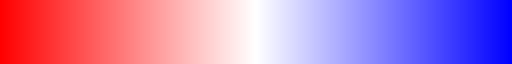

In [20]:
norm=plt.Normalize(-2,2)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
cmap

In [21]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=-69.19517910546156, vcenter=0., vmax=40)

In [22]:
# geometry = [Point(xy) for xy in zip(df_preds_real_vals_sensorly.Longitude, df_preds_real_vals_sensorly.Latitude)]
# gdf = gpd.GeoDataFrame(df_preds_real_vals_sensorly, geometry=geometry)
# gdf = gdf.set_crs(epsg=4326)
# gdf = gdf.to_crs('epsg:3857')

# fig, ax = plt.subplots(figsize=(15,15))
# gdf.plot(column=gdf.Percentage_Increase, ax = ax, markersize = 900,edgecolor = 'black', cmap="RdBu", norm=divnorm,
#          marker='h', legend = True, 
#          legend_kwds={'shrink': 0.9, 'pad':0.01, 'label':'Percentage Increase', 
#                       "orientation": "horizontal"})

# # Change font size on legend
# cb_ax = fig.axes[1]
# cb_ax.tick_params(labelsize=20)
# plt.rcParams.update({'font.size': 35}) # legend title size

# cx.add_basemap(ax, source='https://tiles.stadiamaps.com/tiles/stamen_terrain/{z}/{x}/{y}{r}.png?api_key='+api)
# ax.axis('off')
# ax.set_axis_off()

# fig.savefig("Results/ModelEvaluation/Events/{}_spatial.png".format(special_date), bbox_inches="tight" )

## Make two plots together

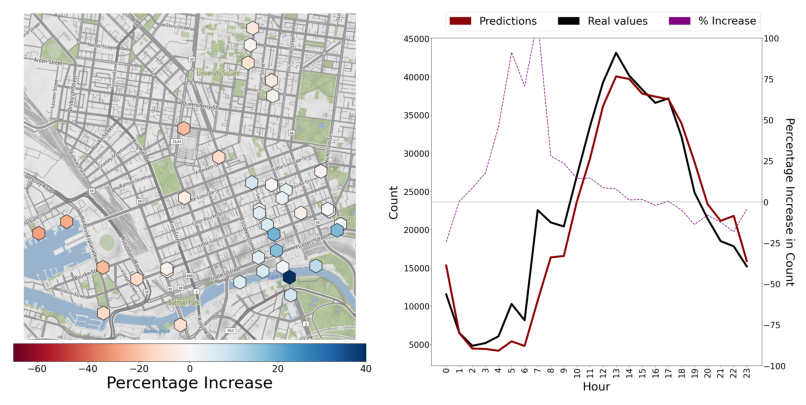

In [23]:
img1 = mpimg.imread('Results/ModelEvaluation/Events/{}_spatial.png'.format(special_date))
img2 = mpimg.imread('Results/ModelEvaluation/Events/{}_lines.png'.format(special_date))

fig, axs = plt.subplots(ncols= 2, nrows=1,figsize = (11,5), gridspec_kw={'wspace': -0.12})
axs[0].imshow(img1)
axs[0].axis('off')
axs[1].imshow(img2)
axs[1].axis('off');
plt.savefig('Results/ModelEvaluation/Events/{}_lines_spatial.png'.format(special_date), bbox_inches='tight')

### More assessment of changes

In [24]:
df_preds_real_vals_hourly.reset_index(inplace=True)

In [25]:
current = df_preds_real_vals_hourly['RealVals'].sum()
previous = df_preds_real_vals_hourly['Preds'].sum()

change_percent = ((float(current)-previous)/previous)*100
change_percent

5.2374707351559815

In [26]:
hours = [3,4,5,6,7,8,9,10]
# hours = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

current = df_preds_real_vals_hourly[df_preds_real_vals_hourly['Hour'].isin(hours)]['RealVals'].sum()
previous = df_preds_real_vals_hourly[df_preds_real_vals_hourly['Hour'].isin(hours)]['Preds'].sum()

change_percent = ((float(current)-previous)/previous)*100
change_percent

40.2233993149274

In [27]:
# # Overall change
# df_preds_real_vals_hourly['RealVals'].sum()/df_preds_real_vals_hourly['Preds'].sum() * 100
# # Change between these hours
# df_preds_real_vals_hourly[df_preds_real_vals_hourly['Hour'].isin([3,4,5,6,7,8,9])]['RealVals'].sum()/df_preds_real_vals_hourly[df_preds_real_vals_hourly['Hour'].isin([3,4,5,6,7,8,9])]['Preds'].sum() * 100

In [28]:
# df_preds_real_vals_sensorly.sort_values(by='Percentage_Increase', ascending = False)
# df_preds_real_vals_sensorly[df_preds_real_vals_sensorly['sensor_id'] ==29]

In [29]:
# Change for one sensor
sensor_29 = df_preds_real_vals[df_preds_real_vals['sensor_id']==29]
sensor_29['Percentage_Increase'] = ((sensor_29['RealVals'] - sensor_29['Preds']) / abs(sensor_29['Preds'])) * 100
sensor_29

/var/folders/bx/3j5z8qc50wl1tcff6xvbf2zh0000gs/T/ipykernel_45196/360426649.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_29['Percentage_Increase'] = ((sensor_29['RealVals'] - sensor_29['Preds']) / abs(sensor_29['Preds'])) * 100


,Preds,RealVals,Hour,sensor_id,Percentage_Increase
986943,171.07,118,0,29,-31.022388
986944,73.96,90,1,29,21.687399
986945,57.40,73,2,29,27.177700
986946,68.42,303,3,29,342.852967
986947,117.64,1548,6,29,1215.878953
986948,1226.32,1637,14,29,33.488812
986949,948.57,1379,15,29,45.376725
986950,668.96,959,16,29,43.356852
986951,737.13,934,17,29,26.707636
986952,458.89,381,18,29,-16.973567
